우리가 살아가는데 중요한 영향을 미치는 강에는 녹조가 발생시 가장 먼저 알아차리게 하는 클로로필-a 수치는 계절에 따른 주기적인 변동성과 외부 환경 요인에 민감하게 반응하는 복합적인 시계열 특성을 지닌다.

조류의 증식은 과거의 농도 패턴이 미래에 영향을 미치는 자기상관성과 더불어, 수온, 영양염류, 하천 유량 등 다양한 독립 변수와의 인과관계에 의해 결정된다. 

따라서 본 분석에서는 데이터 자체의 계절적 추세(SARIMA)를 학습함과 동시에, 수온 및 방류량과 같은 독립 변수들의 영향력을 통합하여 계산할 수 있는 SARIMAX(Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) 모델을 적용할 예정이다. 이를 통해 클로로필-a 수치의 예측 모델을 구해서 수질 변화에 대한 선제적 대응을 하기 위해서 이 프로젝트를 실행시킬려고 한다.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima 
from sklearn.metrics import confusion_matrix, classification_report

from statsmodels.tsa.stattools import adfuller

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from function.water_data import Water
from function.add_dam import Add_Dam

In [2]:
wa=Water()
ad=Add_Dam()

In [3]:
waterDF=pd.concat([wa.api_data(), wa.api_data('2017,2018,2019,2020')], axis=0)
mulgeum_df = waterDF[waterDF['총량지점명'] == '물금'].copy().set_index('일자').dropna()
geumgok_df = waterDF[waterDF['총량지점명'] == '금곡'].copy().set_index('일자').dropna()
damDF = wa.dam()

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  
--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2017-01-16  3.6         7.9        391      13.7  2.4  5.9   5.2   
1    물금 2017-01-02  7.2        

In [4]:
mulgeum_df = ad.month_dam_add(mulgeum_df, damDF).set_index('일자')
geumgok_df = ad.month_dam_add(geumgok_df, damDF).set_index('일자')

In [5]:
mxtrain,mxtest,mytrain,mytest=ad.log_scale(mulgeum_df)
gxtrain,gxtest,gytrain,gytest=ad.log_scale(geumgok_df)

In [6]:
# model = auto_arima(
#     mytrain, 
#     exogenous=mxtrain,
#     m=12,               # 주기를 명확히!
#     seasonal=True, 
#     d=1, D=1,           # 차분을 강제로 시도해보기
#     max_p=5, max_q=5,   # 탐색 범위 확대
#     max_P=2, max_Q=2, 
#     trend='c',          # 상수를 포함하여 평균값 유지 방지
#     stepwise=False      # 모든 조합을 다 뒤지는 모드 (시간은 걸리지만 정확함)
# )

In [7]:
mulgeum_model = auto_arima(
    mytrain, 
    exogenous=mxtrain,      # 외부 변수 (방류량, 강수량 등)
    start_p=1, start_q=1,
    max_p=3, max_q=3,      # 보통 3 내외로 설정
    m=12,                  # 계절성 주기 (월별 데이터면 12)
    seasonal=True,         # 계절성 고려 여부
    d=1,                # d값을 자동으로 찾음
    trace=True,            # 중간 과정을 출력 (학습 상황 확인용)
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=161.058, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=157.585, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=159.137, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=158.228, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=154.666, Time=0.36 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=162.120, Time=0.15 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=151.812, Time=0.32 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=156.354, Time=0.09 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(3,1,0)(2,0,0)[12] intercept   : AIC=152.671, Time=

In [8]:
print(mulgeum_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   76
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood                 -59.127
Date:                            Tue, 30 Dec 2025   AIC                            130.253
Time:                                    09:50:19   BIC                            144.158
Sample:                                01-01-2017   HQIC                           135.805
                                     - 04-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7776      0.146     -5.325      0.000      -1.064      -0.491
ma.L2         -0.1958      0.131   

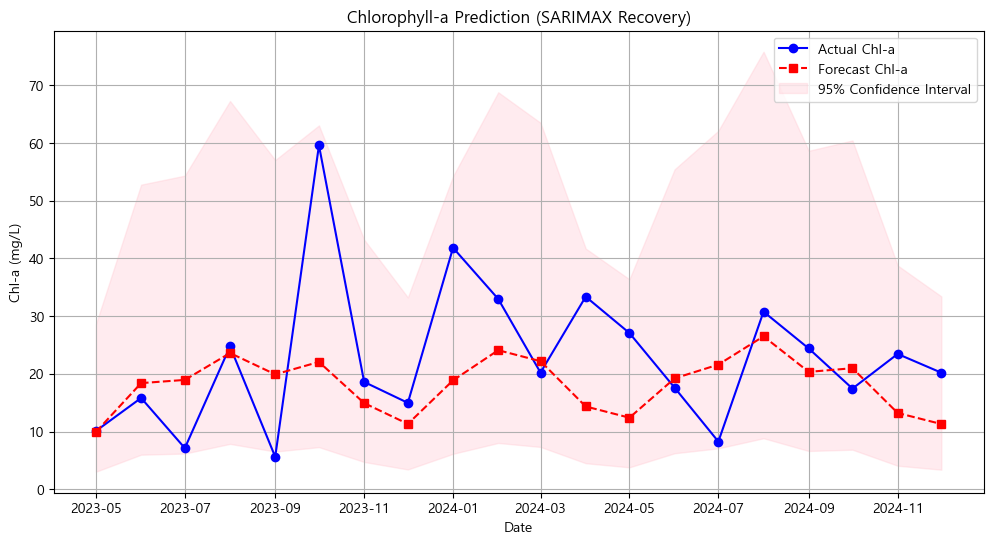

In [9]:
# 1. 예측 실행 (작성하신 코드)
forecast_log, conf_int_log = mulgeum_model.predict(
    n_periods=len(mxtest), 
    exogenous=mxtest, 
    return_conf_int=True
)

# 2. 로그 변환 복원 (np.log1p -> np.expm1)
# 예측값 복원
forecast_final = np.expm1(forecast_log)

# 신뢰구간 복원 (하한값, 상한값)
conf_int_final = np.expm1(conf_int_log)

# 실제값 복원 (비교를 위해 ytest도 복원)
y_test_actual = np.expm1(mytest)

# 3. 결과 시각화
plt.figure(figsize=(12, 6))

# 실제값 (Actual)
plt.plot(y_test_actual.index, y_test_actual, label='Actual Chl-a', color='blue', marker='o')

# 예측값 (Forecast)
plt.plot(y_test_actual.index, forecast_final, label='Forecast Chl-a', color='red', linestyle='--', marker='s')

# 신뢰구간 표시 (Confidence Interval)
plt.fill_between(
    y_test_actual.index, 
    conf_int_final[:, 0], 
    conf_int_final[:, 1], 
    color='pink', alpha=0.3, label='95% Confidence Interval'
)

plt.title('Chlorophyll-a Prediction (SARIMAX Recovery)')
plt.xlabel('Date')
plt.ylabel('Chl-a (mg/L)') # 로그 복원 후 실제 단위
plt.legend()
plt.grid(True)
plt.show()

기존 모델은 외부변수를 상정하기에는 외부 변수가 너무 많아서 시계열 변화에 비해서 클로로필-a에 상관계수가 적음-> 변수를 줄일 필요가 있어 보임

추가된 변수 방류량, 강수량은 그대로 둔다는 가정하에 클로로필-a수치와 연관 없는 변수 3,4개는 삭제가 필요해 보임

삭제 및 정리 대상 변수

BOD & COD (제거 권장): 클로로필-a와 양의 상관관계가 매우 높지만, 이는 '원인'이라기보다 '결과'에 가깝습니다(조류가 많아지면 유기물 수치도 오름). 특히 TOC와 역할이 겹치므로, 유기물 지표는 TOC 하나만 남기는 것이 최신 수질 분석 트렌드에 맞습니다.

수소이온농도(pH) & 용존산소(DO) (제거 권장): 이 변수들 역시 광합성 결과로 변하는 값들입니다. 예측 모델에 넣으면 모델이 "pH가 높으니까 클로로필이 높네"라고 판단하지만, 정작 미래의 pH를 알 수 없으므로 실제 예측에는 도움이 되지 않습니다.

전기전도도(EC) (제거 권장): 주로 염분이나 이온 농도를 나타내는데, 하구역이긴 하지만 클로로필-a의 직접적인 변동 원인으로 보기엔 영향력이 작을 수 있습니다.